In [1]:
import numpy as np
import modin.pandas as pd

import geopandas as gpd
import topojson as tp
from shapely import Polygon

import matplotlib.pyplot as plt

from modin.config import ProgressBar
from tqdm.auto import tqdm

ProgressBar.enable()

In [2]:
annos = pd.read_parquet("wforms-bat.parquet").join(
    pd.read_parquet("wforms-ann.parquet"), how="left"
)

annos = annos[
    (annos["fst_batch"] | annos["snd_batch"])
    & annos["status"].ge(0)
    & ~annos["tt_att"]
    & ~annos.index.str.startswith("#")
]

tokens = (
    pd.read_parquet("tweets-tok.parquet", columns=["doy", "tokens"])
    .explode("tokens")
    .rename(columns={"tokens": "wf"})
)

tokens = tokens[tokens["wf"].isin(annos.index)]

tokens = tokens.join(
    pd.read_parquet("tweets-geo.parquet", columns=["country_code", "reg_istat_code"]),
    how="left",
)

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2023-08-10 13:56:22,660	INFO worker.py:1621 -- Started a local Ray instance.


Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 6:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 7:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 8:   0%           Elapsed time: 00:00, estimated remaining time: ?

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 13:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 14:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 18:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 21:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 20:   0%           Elapsed time: 00:00, estimated remaining time: ?

In [3]:
regions = gpd.read_file("italy-regions.geojson")

# Remove tiny islands (select biggest polygon) and delete lakes (regenerate poly from exterior)
regions["geometry"] = (
    regions["geometry"]
    .apply(
        lambda g: max(g.geoms, key=lambda p: p.area)
        if g.geom_type == "MultiPolygon"
        else g
    )
    .apply(lambda p: Polygon(p.exterior))
)
# Simplify geometry
regions = (
    tp.Topology(regions.to_crs("EPSG:32632"), prequantize=False)
    .toposimplify(2000)
    .to_gdf()
    .to_crs("EPSG:4326")
)

regions.set_index("reg_istat_code", inplace=True)
regions.drop(columns=["reg_name", "reg_istat_code_num"], inplace=True)


regions = regions.merge(
    pd.read_parquet("tweets-tok.parquet", columns=["token_count"])
    .join(
        pd.read_parquet("tweets-geo.parquet", columns=["reg_istat_code"]),
        how="left",
    )
    .groupby("reg_istat_code")
    .sum("token_count")
    ._to_pandas(),
    on="reg_istat_code",
    how="left",
)

Estimated completion of line 26:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 28:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 32:   0%           Elapsed time: 00:00, estimated remaining time: ?

In [4]:
choros = (
    tokens.groupby(["wf", "country_code", "reg_istat_code"], dropna=False)
    .size()
    .reset_index(name="count")
    .merge(pd.DataFrame(regions), on="reg_istat_code", how="left")
)

choros = gpd.GeoDataFrame(choros._to_pandas())

sums = choros.groupby("wf")["count"].sum().to_dict()

sorted_wf = choros.groupby("wf").sum("count")["count"].sort_values(ascending=False)
choros = choros.set_index("wf").loc[sorted_wf.index].reset_index()

choros["cpm"] = 1e6 * choros["count"] / choros["token_count"]

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Exception in thread Thread-58 (call_progress_bar):
Traceback (most recent call last):
  File "/opt/share/spack/spack-0.19.1/opt/spack/linux-ubuntu22.04-x86_64/gcc-12.1.0/python-3.10.8-qkx5vsyopsbqtvrf6y2bf7aviocikm4m/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/share/spack/spack-0.19.1/opt/spack/linux-ubuntu22.04-x86_64/gcc-12.1.0/python-3.10.8-qkx5vsyopsbqtvrf6y2bf7aviocikm4m/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/clusterusers/pbrasolin_eurac/venv/bi/lib/python3.10/site-packages/modin/core/execution/modin_aqp.py", line 61, in call_progress_bar
    futures = [
  File "/home/clusterusers/pbrasolin_eurac/venv/bi/lib/python3.10/site-packages/modin/core/execution/modin_aqp.py", line 61, in <listcomp>
    futures = [
TypeError: 'PandasOnRayDataframePartition' object is not iterable


Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

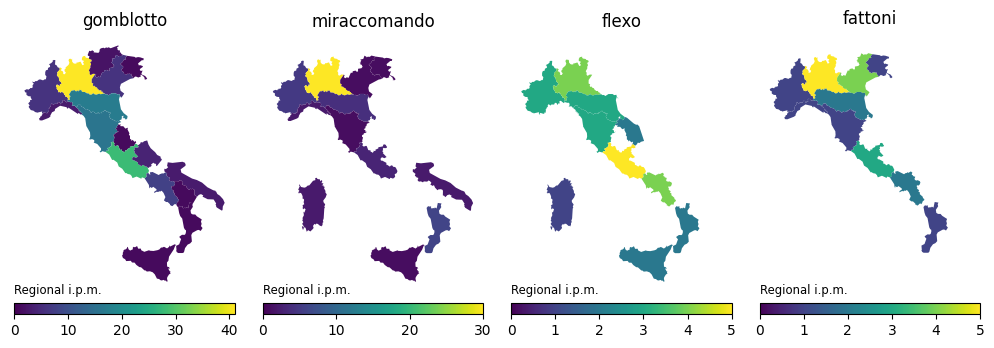

In [5]:
fig, axs = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(10, 10))


def annotate_for_article(data, ax, column="count", **kws):
    wf = data["wf"].iloc[0]

    # cax = ax.inset_axes([0.90, 0.5, 0.06, 0.5])
    # cax = ax.inset_axes([0, 0, 0.5, 0.1])
    data.plot(
        column=column,
        ax=ax,
        legend=True,
        legend_kwds={"orientation": "horizontal", "pad": 0.01},
        # legend_kwds={"label":"horizontal"},
        # cax=cax,
        cmap="viridis",
        vmin=0,
    )
    # cax.yaxis.set_ticks_position('left')

    # ax.set_xlim(6.616667, 18.516667)
    # ax.set_ylim(36.688444, 47.083333)
    ax.set_title(wf)
    ax.axis("off")
    ax.text(
        0,
        0,
        "Regional i.p.m.",
        transform=ax.transAxes,
        fontsize="small",
    )


annotate_for_article(choros[choros["wf"].eq("gomblotto")], axs[0])
annotate_for_article(choros[choros["wf"].eq("miraccomando")], axs[1])
annotate_for_article(choros[choros["wf"].eq("flexo")], axs[2])
annotate_for_article(choros[choros["wf"].eq("fattoni")], axs[3])

plt.tight_layout()
plt.savefig("choros-sample.pdf", format="pdf", bbox_inches="tight")
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

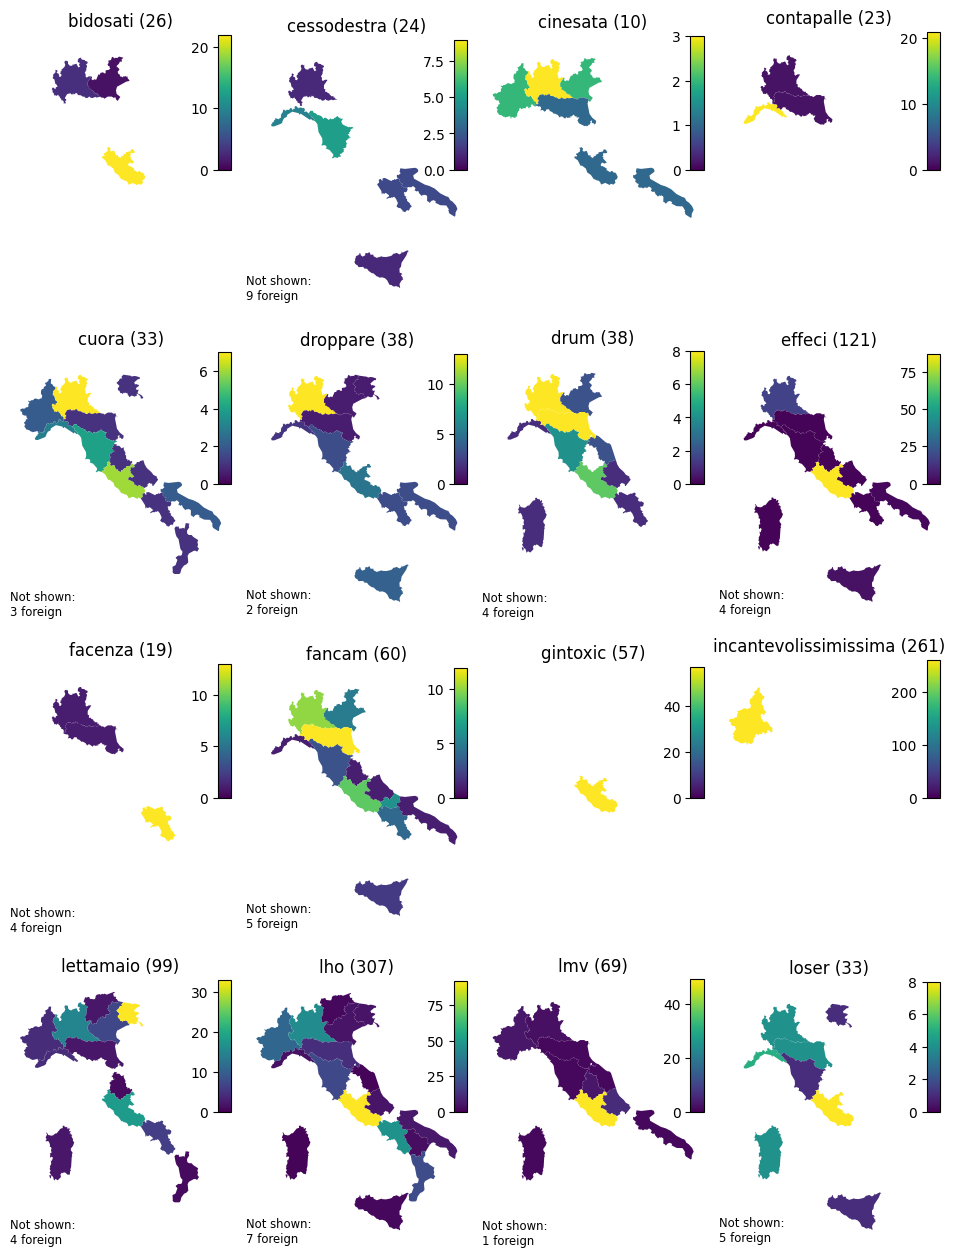

  0%|          | 0/16 [00:00<?, ?it/s]

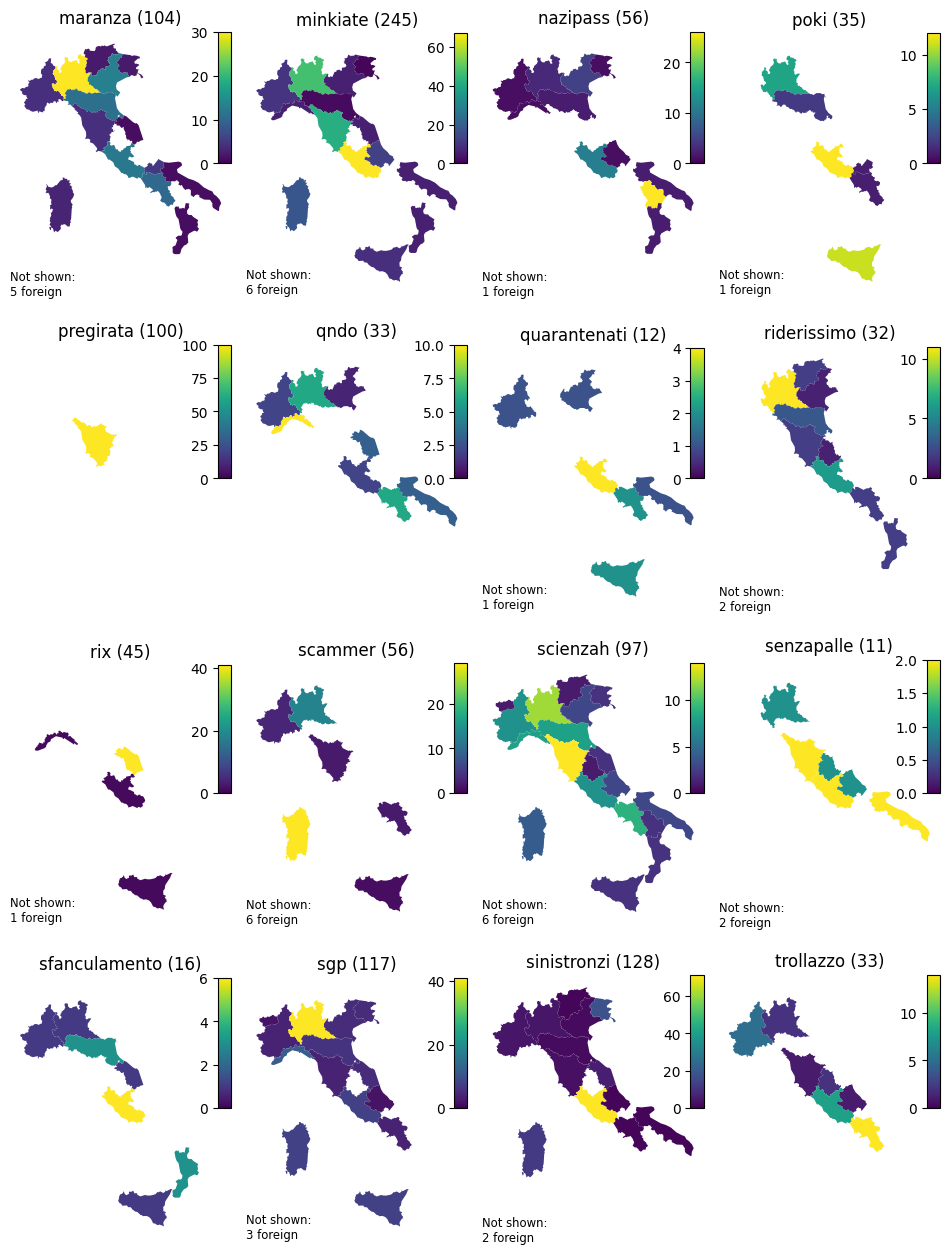

In [6]:
def annotate_for_appendix(data, ax, column="count", pbar=None, **kws):
    if pbar:
        pbar.update(1)
    wf = data["wf"].iloc[0]

    if data["reg_istat_code"].any():
        cax = ax.inset_axes([0.94, 0.5, 0.06, 0.5])
        data.plot(
            column=column,
            ax=ax,
            legend=True,
            cax=cax,
            cmap="viridis",
            vmin=0,
        )
        cax.yaxis.set_ticks_position("left")

    # ax.set_xlim(6.616667, 18.516667)
    # ax.set_ylim(36.688444, 47.083333)
    ax.axis("off")

    ax.set_title("{} ({})".format(wf, sums[wf]))
    foreign = data[data["reg_istat_code"].isna() & ~data["country_code"].eq("IT")][
        "count"
    ].sum()
    generic = data[data["reg_istat_code"].isna() & data["country_code"].eq("IT")][
        "count"
    ].sum()
    warning = ["Not shown:"]
    if generic:
        warning.append("{} generic".format(generic))
    if foreign:
        warning.append("{} foreign".format(foreign))

    if generic or foreign:
        ax.text(
            0,
            0,
            "\n".join(warning),
            transform=ax.transAxes,
            fontsize="small",
        )


sorted_keys = sorted(sums, key=sums.get, reverse=True)

extra = [
    "bidosati",
    "cessodestra",
    "cinesata",
    "contapalle",
    "cuora",
    "droppare",
    "drum",
    "effeci",
    #"f4scist4",
    "facenza",
    "fancam",
    #"fattoni",
    #"flexo",
    "gintoxic",
    #"gomblotto",
    "incantevolissimissima",
    "lettamaio",
    "lho",
    "lmv",
    "loser",
    "maranza",
    "minkiate",
    #"miraccomando",
    "nazipass",
    "poki",
    "pregirata",
    "qndo",
    "quarantenati",
    "riderissimo",
    "rix",
    "scammer",
    "scienzah",
    "senzapalle",
    "sfanculamento",
    "sgp",
    "sinistronzi",
    "trollazzo",
]

fig, axs = plt.subplots(4, 4, sharey=True, sharex=True, figsize=(4*3*4/5, 4*4*4/5))
for idx, ax in tqdm(enumerate(axs.ravel()), total=16):
   annotate_for_appendix(choros[choros["wf"].eq(extra[idx])], ax)
plt.tight_layout()
plt.savefig("choros-more-1.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig, axs = plt.subplots(4, 4, sharey=True, sharex=True, figsize=(4*3*4/5, 4*4*4/5))
for idx, ax in tqdm(enumerate(axs.ravel()), total=16):
   annotate_for_appendix(choros[choros["wf"].eq(extra[idx+16])], ax)
plt.tight_layout()
plt.savefig("choros-more-2.pdf", format="pdf", bbox_inches="tight")
plt.show()